#**Определение тональности к именованным сущностям в новостных текстах**

In [ ]:
!pip install transformers
!pip install datasets

In [2]:
import torch.nn as nn
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoModel
from datasets import Dataset

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np

from nltk import FreqDist
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import collections
from sklearn.metrics import classification_report

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

## Exploratory Data Analisys

In [5]:
train_data = pd.read_csv('./data/train_data.csv', sep='\t')
val_data = pd.read_csv('./data/val_data.csv', sep='\t')

train_data = train_data.drop('Unnamed: 0', axis=1)

In [6]:
train_data['idx'] = train_data.index
val_data['idx'] = val_data.index

In [7]:
freq = FreqDist(train_data['entity'])
print(f"Количество уникальных сущностей: {len(set(freq))}","\n")
print(f"* 20 наиболее частых сущностей * \n{freq.most_common(20)}", "\n")

Количество уникальных сущностей: 2885 

* 20 наиболее частых сущностей * 
[('США', 124), ('России', 79), ('Google', 25), ('Китая', 25), ('Афганистане', 23), ('Украины', 22), ('РФ', 21), ('Россия', 19), ('Германии', 18), ('правительство', 18), ('НАТО', 18), ('Италии', 16), ('Сирии', 15), ('Великобритании', 15), ('Грузии', 13), ('Мадуро', 11), ('Израиль', 11), ('Apple', 11), ('ХАМАС', 11), ('полиции', 10)] 



In [8]:
data_gb_tag = train_data.groupby(['entity_tag','label']).count()['sentence']
data_gb_tag

entity_tag    label
COUNTRY       -1        212
               0        920
               1        142
ORGANIZATION  -1        261
               0       1040
               1        186
PERSON        -1        363
               0       1150
               1        421
Name: sentence, dtype: int64

Посмотрим на гистограмму типов именнованных сущностей, а так же их распределения по целевому значению

In [ ]:
fig = go.Figure(px.histogram(train_data,
                             x = 'entity_tag',
                             pattern_shape = 'label')
               )
fig.update_layout(barmode = 'group',
                  title = 'Train data')
fig.show()

In [ ]:
fig = go.Figure(px.histogram(train_data,
                             x = 'label',
                             pattern_shape = 'entity_tag')
               )
fig.update_layout(barmode = 'group',
                  title = 'Train data')
fig.show()

In [ ]:
# seq_len_train = [len(str(i).split()) for i in tokenized_train['input_ids']]
# seq_len_test = [len(str(i).split()) for i in tokenized_val['input_ids']]
# max_seq_len = max(max(seq_len_test), max(seq_len_train))
# max_seq_len

In [9]:
max_seq_len = 150

# Подход 1

Будем использовать предобученную модель cointegrated/rubert-tiny2 для классификации последовательностей.

Логика подхода: с помощью токенайзера модели объединяем предложения вместе с именованной сущностью, подаем на вход модели BERT, классифицируем полученные CLS токены с помощью классификатора модели.

In [18]:
checkpoint1 = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint1, num_labels=3)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not 

In [ ]:
model

Для дообучения будем использовать Trainer от HuggingFace. Зададим параметры trainer'а.

In [ ]:
training_args = TrainingArguments(output_dir = "test-trainer",
                                  evaluation_strategy = 'epoch',
                                  per_device_train_batch_size = 6,
                                  per_device_eval_batch_size = 6,
                                  num_train_epochs = 5,
                                  report_to='none',
                                  learning_rate = 1e-05)

Определим функцию токенизации для нашей модели.

In [36]:
def tokenize_function(data):
    return tokenizer(data['sentence'], data['entity'], truncation=True, max_length = max_seq_len, padding = 'max_length', add_special_tokens=True)

In [10]:
idxs = ['sentence', 'entity','label','idx']
train = train_data[idxs]
val = val_data[idxs]

train['label'] = train['label'].replace(-1, 2)
val['label'] = val['label'].replace(-1, 2)

validation, test = train_test_split(val, test_size = 0.25, 
                                    stratify = val['label'], 
                                    random_state = 0)

train_entity = train_data['entity_tag']
val_entity = val_data.iloc[validation.idx]['entity_tag']
test_entity = val_data.iloc[test.idx]['entity_tag']

train_dataset = Dataset.from_pandas(train)
validation_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)

<ipython-input-10-17035ee1dc39>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['label'] = train['label'].replace(-1, 2)
<ipython-input-10-17035ee1dc39>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['label'] = val['label'].replace(-1, 2)


In [11]:
train_entity = train_data.entity_tag.astype('str')
val_entity = val_data.iloc[validation.idx.tolist()].entity_tag.astype('str')
test_entity = val_data.iloc[test.idx.tolist()].entity_tag.astype('str')

train_entity = pd.get_dummies(train_entity)
val_entity = pd.get_dummies(val_entity)
test_entity = pd.get_dummies(test_entity)

Данные содержат:

In [ ]:
print(f"Train dataset: {train_entity.shape[0]} строк")
print(train_entity.value_counts(), '\n')

print(f"Validation dataset: {val_entity.shape[0]}")
print(val_entity.value_counts(), '\n')

print(f"Test dataset: {test_entity.shape[0]} строк")
print(test_entity.value_counts(), '\n')

Train dataset: 4695 строк
COUNTRY  ORGANIZATION  PERSON
0        0             1         1934
         1             0         1487
1        0             0         1274
dtype: int64 

Validation dataset: 1532
COUNTRY  ORGANIZATION  PERSON
0        0             1         642
         1             0         497
1        0             0         393
dtype: int64 

Test dataset: 511 строк
COUNTRY  ORGANIZATION  PERSON
0        0             1         215
         1             0         156
1        0             0         140
dtype: int64 



In [37]:
tokenized_train = train_dataset.map(tokenize_function)
tokenized_val = validation_dataset.map(tokenize_function)
tokenized_test = test_dataset.map(tokenize_function)

Map:   0%|          | 0/4695 [00:00<?, ? examples/s]

Map:   0%|          | 0/2043 [00:00<?, ? examples/s]

Map:   0%|          | 0/511 [00:00<?, ? examples/s]

In [ ]:
!pip install evaluate

Определим как будем считать метрику. Возьмем accuracy.

In [ ]:
import evaluate
metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Задаем Trainer

In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_train,
    eval_dataset = tokenized_val,
    data_collator = data_collator,
    # tokenizer = tokenizer,
    compute_metrics = compute_metrics)

Дообучим модель на нашем датасете.

In [ ]:
# trainer.train()

Сохраним дообученную модель, чтобы в дальнейшем использовать ее.

In [ ]:
save_directory = './pretrained_edz_trainer'
# trainer.save_model(save_directory)

Заново загрузим дообученную модель. Теперь мы можем использовать ее для классификации тестовых данных

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(save_directory, num_labels=3)
trainer_FT = Trainer(model = model)

In [ ]:
def get_prediction():
    test_pred = trainer_FT.predict(tokenized_test)
    labels = np.argmax(test_pred.predictions, axis = -1)
    return labels
pred = get_prediction()

Посмотрим на получившийся результат.

In [ ]:
reports = []
reports.append(classification_report(test['label'], pred))
print(reports[0])

              precision    recall  f1-score   support

           0       0.74      0.85      0.79       339
           1       0.49      0.33      0.39        79
           2       0.52      0.40      0.45        93

    accuracy                           0.68       511
   macro avg       0.58      0.52      0.55       511
weighted avg       0.66      0.68      0.67       511



In [ ]:
predd = pd.DataFrame(pred)
predd.to_csv('predictions.csv', index=False)

# Подход 2.

Будем использовать ту же модель cointegrated/rubert-tiny2, однако не будем ее переобучать.

Логика подхода: вместо совместного токенизирования предложения и именованной сущности, мы будем проводить операции над ними отдельно. Затем объединим получившиеся для них CLS токены, для дополнительной точности добавим тип именованной сущности (закодируем этот категориальный признак с помощью one-hot кодирования). На получившемся наборе векторов обучим классификатор.

In [19]:
model = AutoModel.from_pretrained(checkpoint1)
model

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(83828, 312, padding_idx=0)
    (position_embeddings): Embedding(2048, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-2): 3 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
   

In [14]:
import torch

In [13]:
train_st = train.drop(['label', 'idx'], axis = 1)
val_st = validation.drop(['label', 'idx'], axis = 1)
test_st = test.drop(['label', 'idx'], axis = 1)

In [20]:
train_vector = []
val_vector = []
test_vector = []
for idx, row in train_st.iterrows():
    input_ids_sent = torch.tensor(tokenizer.encode(row.sentence)).unsqueeze(0)
    input_ids_ner = torch.tensor(tokenizer.encode(row.entity)).unsqueeze(0)

    out_sent = model(input_ids_sent)
    out_ner = model(input_ids_ner)

    cls_token_sent = out_sent.last_hidden_state[:,0,:].detach().numpy()
    cls_token_ner = out_ner.last_hidden_state[:,0,:].detach().numpy()
    
    train_vector.append(np.concatenate((cls_token_sent, cls_token_ner), axis = 1))

for idx, row in val_st.iterrows():
    input_ids_sent = torch.tensor(tokenizer.encode(row.sentence)).unsqueeze(0)
    input_ids_ner = torch.tensor(tokenizer.encode(row.entity)).unsqueeze(0)

    out_sent = model(input_ids_sent)
    out_ner = model(input_ids_ner)

    cls_token_sent = out_sent.last_hidden_state[:,0,:].detach().numpy()
    cls_token_ner = out_ner.last_hidden_state[:,0,:].detach().numpy()
    
    val_vector.append(np.concatenate((cls_token_sent, cls_token_ner), axis = 1))

for idx, row in test_st.iterrows():
    input_ids_sent = torch.tensor(tokenizer.encode(row.sentence)).unsqueeze(0)
    input_ids_ner = torch.tensor(tokenizer.encode(row.entity)).unsqueeze(0)

    out_sent = model(input_ids_sent)
    out_ner = model(input_ids_ner)

    cls_token_sent = out_sent.last_hidden_state[:,0,:].detach().numpy()
    cls_token_ner = out_ner.last_hidden_state[:,0,:].detach().numpy()
    
    test_vector.append(np.concatenate((cls_token_sent, cls_token_ner), axis = 1))

In [21]:
train_array = np.vstack(train_vector)
val_array = np.vstack(val_vector)
test_array = np.vstack(test_vector)

X_train = np.concatenate((train_array, val_array), axis = 0)
y_train = np.concatenate((train['label'].to_numpy(), validation['label'].to_numpy()), axis = 0)

tr_entity = np.concatenate((train_entity.to_numpy(), val_entity.to_numpy()), axis = 0)

X_train = np.concatenate((X_train, tr_entity), axis = 1)
test_array = np.concatenate((test_array, test_entity.to_numpy()), axis = 1)

In [22]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve

In [23]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
        '''
        Plots the ROC Curve by using the list of coordinates (tpr and fpr).
        
        Args:
            tpr: The list of TPRs representing each coordinate.
            fpr: The list of FPRs representing each coordinate.
            scatter: When True, the points used on the calculation will be plotted with the line (default = True).
        '''
        if ax == None:
            plt.figure(figsize = (5, 5))
            ax = plt.axes()
        
        if scatter:
            sns.scatterplot(x = fpr, y = tpr, ax = ax)
        sns.lineplot(x = fpr, y = tpr, ax = ax)
        sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
        plt.xlim(-0.05, 1.05)
        plt.ylim(-0.05, 1.05)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")

In [24]:
classes = [0, 1, 2]
word_classes = ['Нейтральный', 'Положительный', 'Отрицательный']

def create_roc_auc_curves_OvR(y_pred, y_prob):
    bins = [i/20 for i in range(20)] + [1] 
    roc_auc_ovr = {}
    plt.figure(figsize = (16, 8))
    for i in range(len(classes)):
        # Gets the class
        c = classes[i]
        c_name = word_classes[i]
        # Prepares an auxiliar dataframe to help with the plots
        df_aux = pd.DataFrame(columns = ['class', 'prob'])
        df_aux['class'] = [1 if y == c else 0 for y in y_pred]
        df_aux['prob'] = y_prob[:, i]
        df_aux = df_aux.reset_index(drop = True)
        
        # Plots the probability distribution for the class and the rest
        ax = plt.subplot(2, 3, i+1)
        sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
        ax.set_title(c_name)
        ax.legend([f"Class: {c_name}", "Rest"])
        ax.set_xlabel(f"P(x = {c_name})")

        # Calculates the ROC Coordinates and plots the ROC Curves
        ax_bottom = plt.subplot(2, 3, i+4)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
        plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
        ax_bottom.set_title("ROC Curve OvR")
        
        # Calculates the ROC AUC OvR
        roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    plt.tight_layout()
    avg_roc_auc = 0
    i = 0
    for k in roc_auc_ovr:
        avg_roc_auc += roc_auc_ovr[k]
        i += 1
        print(f"{word_classes[k]} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")

In [25]:
reports = []

### ROC-AUC CURVE One vs Rest: GradientBoosting

In [29]:
clf_grad = GradientBoostingClassifier(n_estimators=100)
clf_grad.fit(X_train, y_train)
y_pred_grad = clf_grad.predict(test_array)
y_prob_grad = clf_grad.predict_proba(test_array)
reports.append(classification_report(test['label'], y_pred_grad, digits=4))

Нейтральный ROC AUC OvR: 0.9966
Положительный ROC AUC OvR: 0.9974
Отрицательный ROC AUC OvR: 0.9992


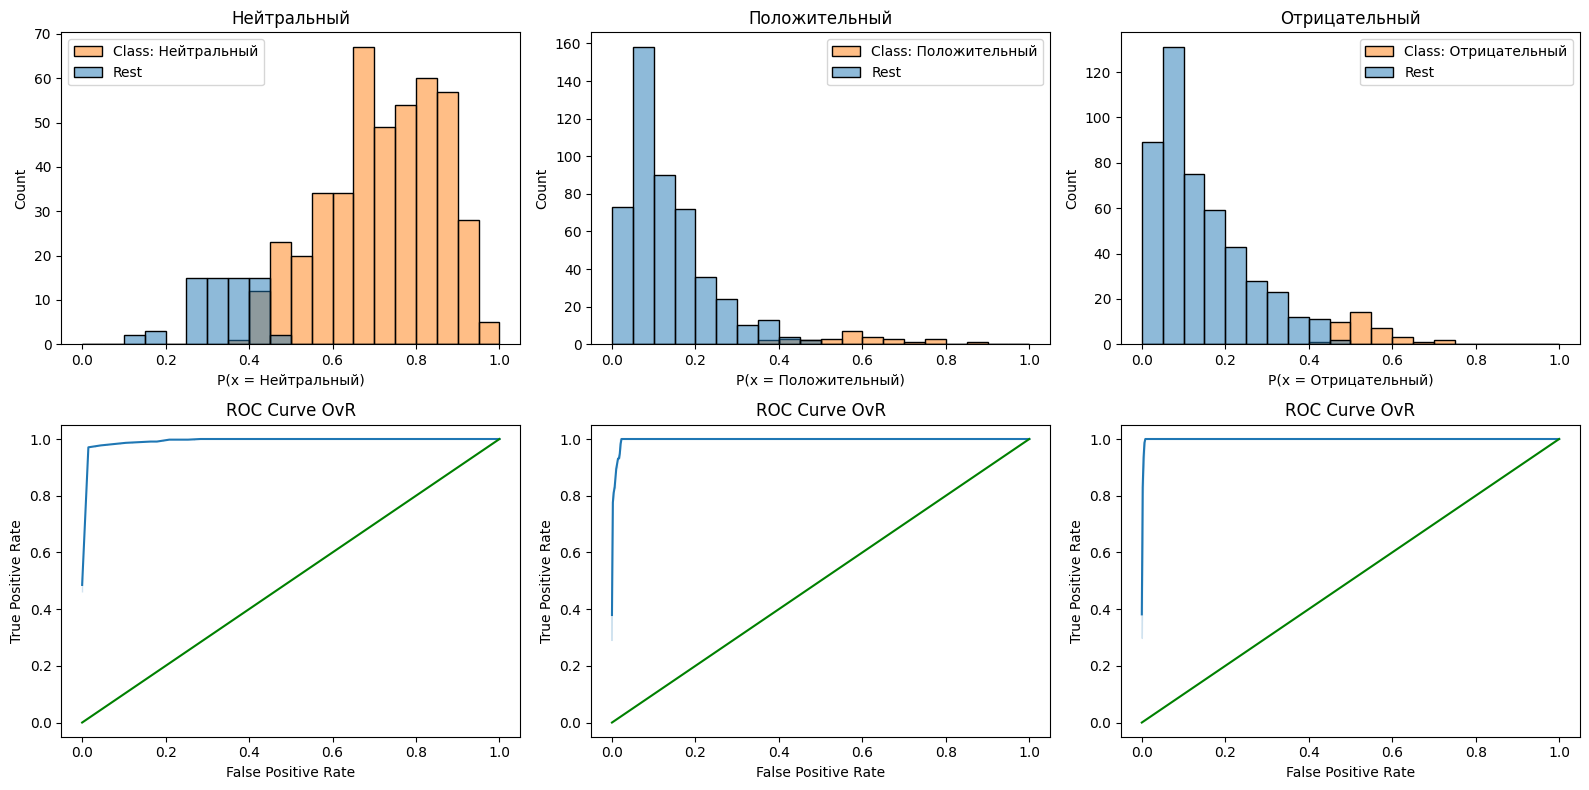

In [30]:
create_roc_auc_curves_OvR(y_pred_grad, y_prob_grad)

### ROC-AUC CURVE One vs Rest: AdaBoost

In [31]:
clf_ada = AdaBoostClassifier(n_estimators=100)
clf_ada.fit(X_train, y_train)
y_pred_ada = clf_ada.predict(test_array)
y_prob_ada = clf_ada.predict_proba(test_array)
reports.append(classification_report(test['label'], y_pred_ada, digits=4))

Нейтральный ROC AUC OvR: 0.8448
Положительный ROC AUC OvR: 0.9607
Отрицательный ROC AUC OvR: 0.9744


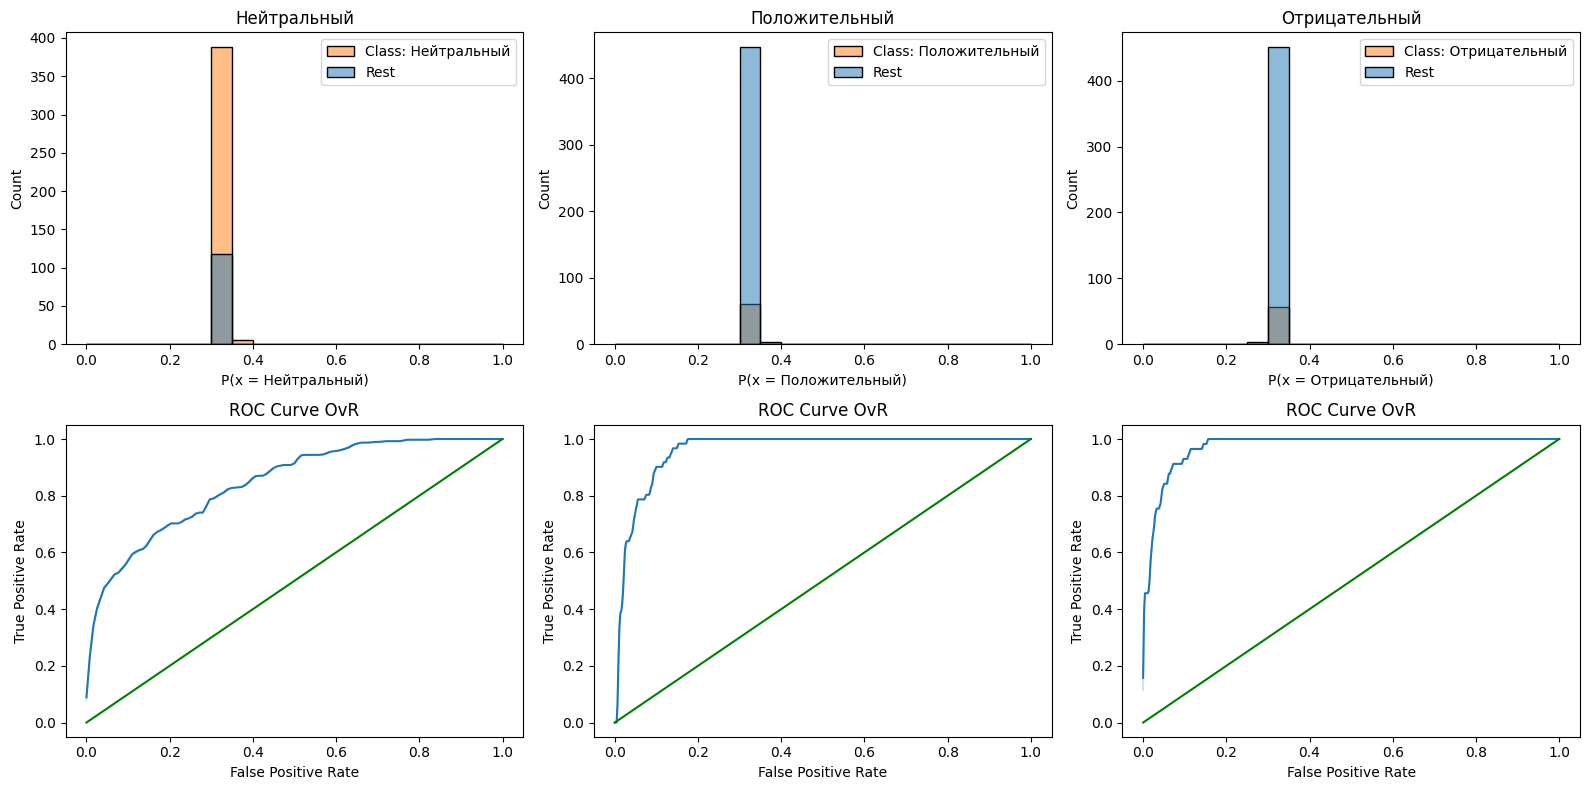

In [32]:
create_roc_auc_curves_OvR(y_pred_ada, y_prob_ada)

### ROC-AUC CURVE One vs Rest: RandomForest

In [33]:
clf_rf = RandomForestClassifier(n_estimators = 100)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(test_array)
y_prob_rf = clf_rf.predict_proba(test_array)
reports.append(classification_report(test['label'], y_pred_rf, digits=4))

Нейтральный ROC AUC OvR: 0.9974
Положительный ROC AUC OvR: 0.9981
Отрицательный ROC AUC OvR: 0.9968


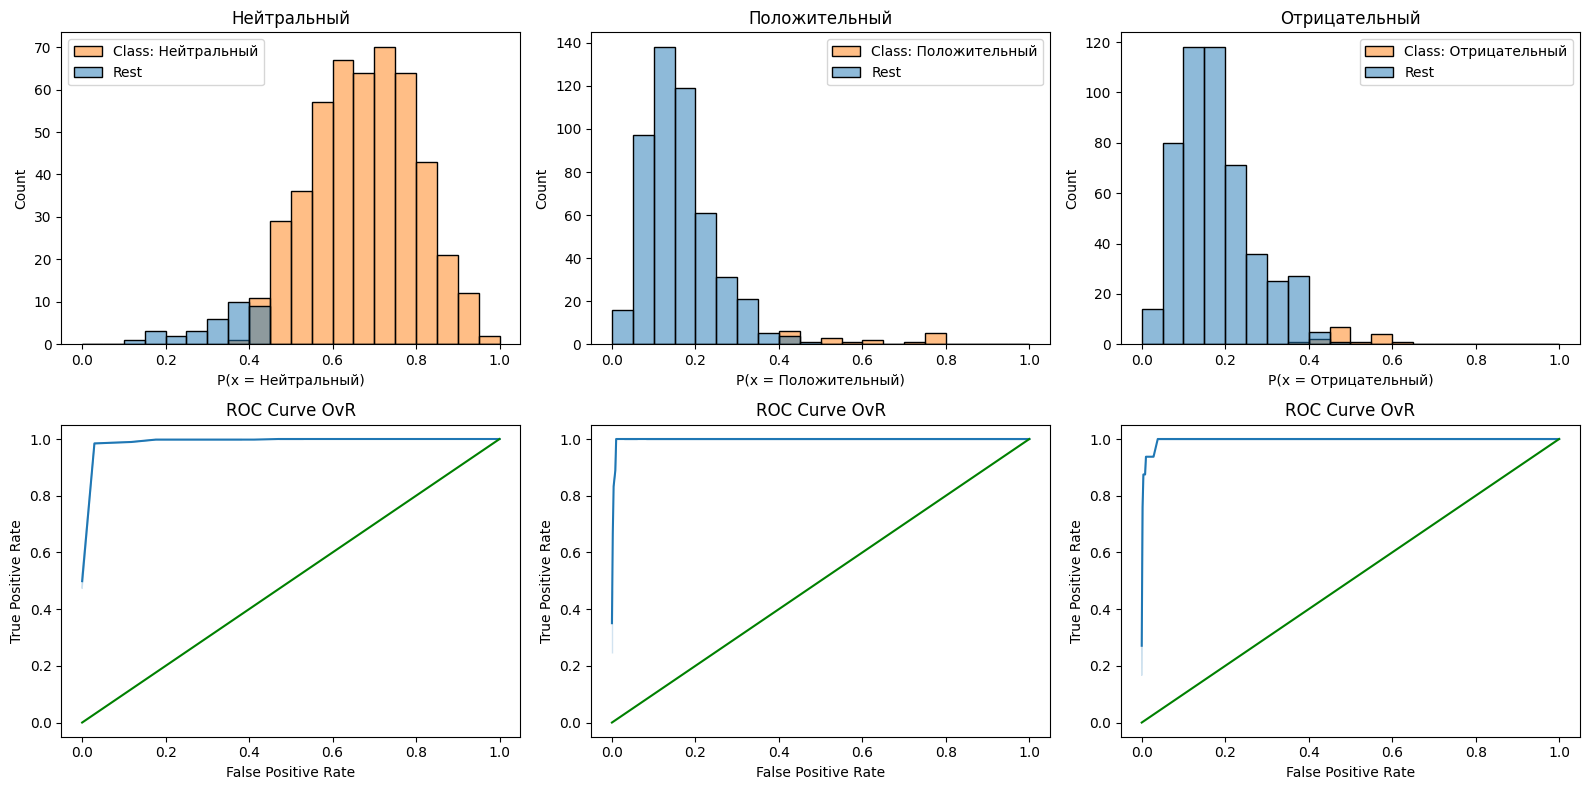

In [34]:
create_roc_auc_curves_OvR(y_pred_rf, y_prob_rf)

### ROC-AUC CURVE One vs Rest: LogisticRegression

In [ ]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(test_array)
y_prob_lr = clf_lr.predict_proba(test_array)
reports.append(classification_report(test['label'], y_pred_lr, digits=4))

Нейтральный ROC AUC OvR: 0.9983
Положительный ROC AUC OvR: 0.9990
Отрицательный ROC AUC OvR: 0.9987


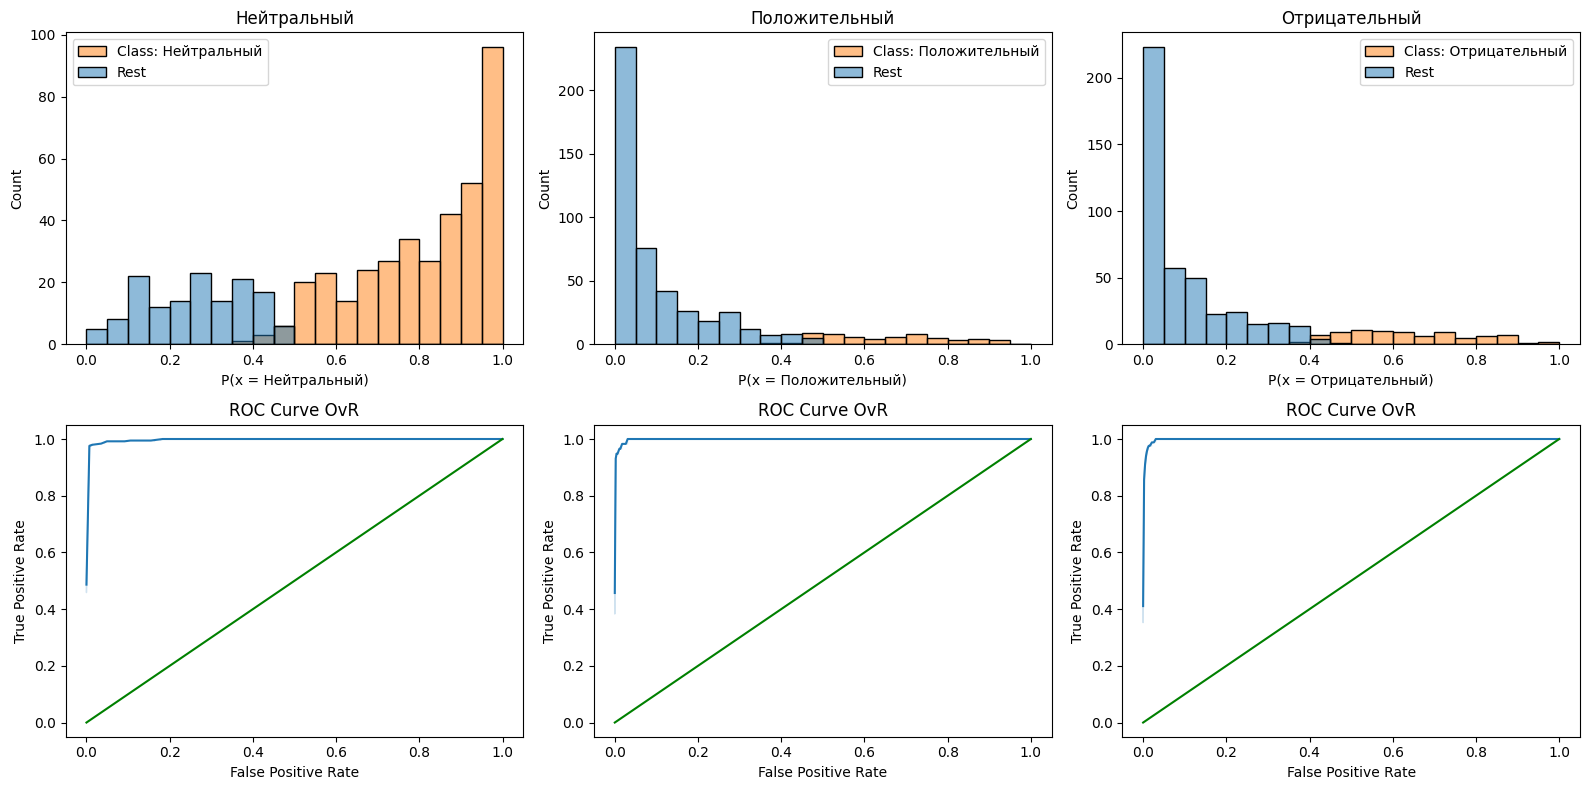

In [28]:
create_roc_auc_curves_OvR(y_pred_lr, y_prob_lr)

### Classification repors

In [ ]:
methods = ['GradientBoostingClassifier', 'AdaBoostClassifier', 'RandomForestClassifier', 'LogisticRegression']

for i, k in enumerate(reports):
    print(f'Метод: {methods[i]}\n{k}\n\n')

Метод: GradientBoostingClassifier
              precision    recall  f1-score   support

           0     0.7162    0.9381    0.8123       339
           1     0.5862    0.2152    0.3148        79
           2     0.6053    0.2473    0.3511        93

    accuracy                         0.7006       511
   macro avg     0.6359    0.4669    0.4927       511
weighted avg     0.6759    0.7006    0.6514       511



Метод: AdaBoostClassifier
              precision    recall  f1-score   support

           0     0.7252    0.8407    0.7787       339
           1     0.4262    0.3291    0.3714        79
           2     0.4386    0.2688    0.3333        93

    accuracy                         0.6575       511
   macro avg     0.5300    0.4795    0.4945       511
weighted avg     0.6268    0.6575    0.6347       511



Метод: RandomForestClassifier
              precision    recall  f1-score   support

           0     0.7011    0.9823    0.8182       339
           1     0.7391    0.2152  